In [2]:
# Verificação e instalação de dependências
import sys
import subprocess
import pickle

def check_and_install_packages():
    """
    Verifica e instala pacotes necessários se houver problemas de compatibilidade
    """
    required_packages = [
        'numpy>=1.24.0',
        'pandas>=1.5.0',
        'scikit-learn>=1.3.0',
        'matplotlib>=3.7.0',
        'seaborn>=0.12.0'
    ]
    
    for package in required_packages:
        try:
            if 'numpy' in package:
                import numpy as np
                print(f"✅ NumPy version: {np.__version__}")
            elif 'pandas' in package:
                import pandas as pd
                print(f"✅ Pandas version: {pd.__version__}")
            elif 'scikit-learn' in package:
                import sklearn
                print(f"✅ Scikit-learn version: {sklearn.__version__}")
            elif 'matplotlib' in package:
                import matplotlib
                print(f"✅ Matplotlib version: {matplotlib.__version__}")
            elif 'seaborn' in package:
                import seaborn as sns
                print(f"✅ Seaborn version: {sns.__version__}")
        except ImportError as e:
            print(f"❌ Erro ao importar {package}: {e}")
            print(f"🔄 Instalando {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    
    print("🎉 Todas as dependências estão funcionando corretamente!")

# Executar verificação
try:
    check_and_install_packages()
except Exception as e:
    print(f"⚠️ Problema detectado: {e}")
    print("🔄 Reinstalando NumPy especificamente...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--force-reinstall", "numpy==1.24.4"])

✅ NumPy version: 2.3.3
✅ Pandas version: 2.3.3
✅ Scikit-learn version: 1.7.2
✅ Matplotlib version: 3.10.7
✅ Seaborn version: 0.13.2
🎉 Todas as dependências estão funcionando corretamente!


# Análise de Ganho de Informação e Mutual Information
O ganho de informação é realizado no dataset de treino
Este notebook calcula o ganho de informação e mutual information para o dataset SVM.
- **Ganho de Informação**: Mede a redução na entropia após dividir o dataset com base em um atributo
- **Mutual Information**: Mede a dependência mútua entre duas variáveis

In [3]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import warnings
import pickle
import lib_analise 
warnings.filterwarnings('ignore')

In [4]:
#Variáveis globais


info_modelo = lib_analise.get_info_modelo()  # para garantir que a função está carregada da
nome_dataset = info_modelo['nome_dataset']
arq_dataset_csv = info_modelo['parametros']['arq_dataset_csv']
arq_dataset_pkl = info_modelo['parametros']['arq_dataset_pkl']

config = {}
config['drop_campos_altamente_correlacionados'] = True




In [5]:
# datasets = lib_analise.get_dataset_analise(analise_ganho_de_informacao=True)

In [24]:
# Carregar os datasets de teste, treino e validação do arquivo pickle
print("📂 Carregando datasets preprocessados...")


import pickle
import numpy as np
import pandas as pd

# Verificar se o arquivo existe
import os
if not os.path.exists(arq_dataset_pkl):
    print(f"❌ Arquivo pickle não encontrado: {arq_dataset_pkl}")
    print("🔄 Executando carregamento direto do CSV...")
    # Carregar diretamente do CSV se o pickle não existir
    raise FileNotFoundError("Pickle não encontrado")

# Carregar o arquivo pickle


datasets = lib_analise.get_dataset_analise(analise_ganho_de_informacao=False)
# Extrair os datasets
X_train = datasets['X_train']
X_test = datasets['X_test']
X_val = datasets['X_val']
y_train = datasets['y_train']
y_test = datasets['y_test']
y_val = datasets['y_val']
X_train_scaled = datasets['X_train_scaled']
X_test_scaled = datasets['X_test_scaled']
X_val_scaled = datasets['X_val_scaled']
classes_mapping = datasets['classes_mapping']
features_ganho_informacao  = datasets['features_ganho_informacao']

print("✅ Datasets carregados com sucesso!")
print(f"   • X_train shape: {X_train.shape}")
print(f"   • X_test shape: {X_test.shape}")
print(f"   • X_val shape: {X_val.shape}")
print(f"   • Classes mapping: {classes_mapping}")

# Usar os dados preprocessados para análise
print("\n📊 Usando dados preprocessados para análise de ganho de informação...")



📂 Carregando datasets preprocessados...
X_train_scaled.shape (32259, 122)
X_test_scaled.shape (24194, 122)
X_val_scaled.shape (24195, 122)
X_train.shape (32259, 107)
X_test.shape (24194, 107)
X_val.shape (24195, 107)
✅ Datasets carregados com sucesso!
   • X_train shape: (32259, 107)
   • X_test shape: (24194, 107)
   • X_val shape: (24195, 107)
   • Classes mapping: {'interf': np.int64(0), 'normal': np.int64(1)}

📊 Usando dados preprocessados para análise de ganho de informação...


Features altamente correlacionadas (>0.95): ['mean_os_mem_pgpgin', 'mean_os_mem_pgpgout', 'mean_os_net_packets_recv', 'mean_process_cpu_children_user', 'mean_process_disk_read_count', 'mean_process_disk_write_bytes', 'mean_process_net_tx_drop', 'mean_process_net_tx_packets', 'mean_container_disk_8:0_sync', 'mean_container_disk_8:0_total', 'mean_container_disk_8:0_write', 'mean_container_mem_pgpgin', 'mean_container_mem_rss', 'mean_container_net_rx_drop', 'mean_container_net_tx_drop']


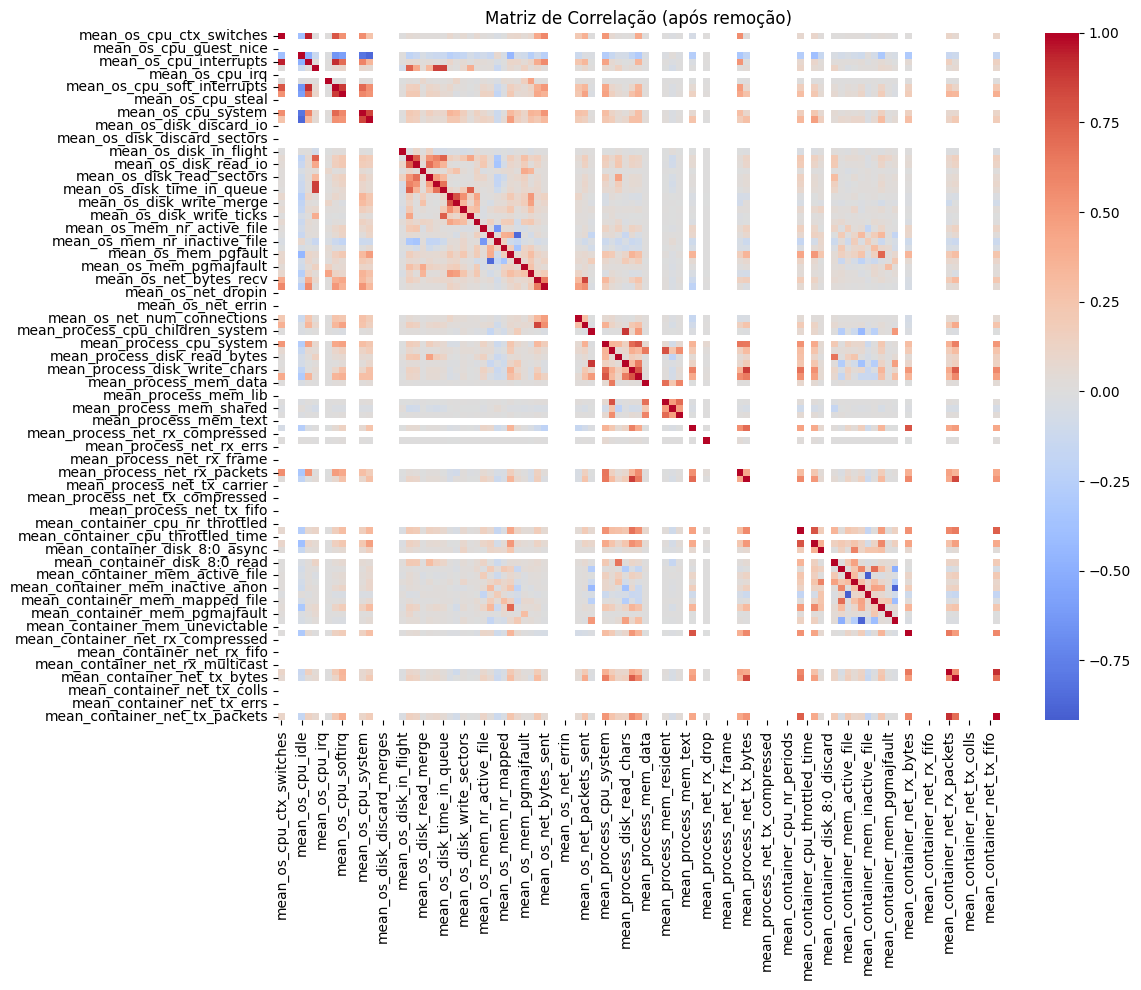

122
15
107
107


In [7]:
# Identifica campos altamente correlacionados
import lib_analise
def drop_campos_altamente_correlacionados(X, threshold=0.95):
    """
    Remove features altamente correlacionadas com base em um limiar.
    """
    correlation_matrix = X.corr().abs()

    # Encontrar pares com alta correlação
    upper_triangle = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )

    # Features para remover (correlação > 0.95)
    # avaliar se é interessante fazer um loop junto com o gridsearch para avaliar o melhor threshold
    to_drop = [column for column in upper_triangle.columns 
            if any(upper_triangle[column] > 0.95)]

    print(f"Features altamente correlacionadas (>{threshold}): {to_drop}")

    # Remover
    X_no_corr = X.drop(columns=to_drop)

    # Visualizar matriz de correlação
    plt.figure(figsize=(12, 10))
    sns.heatmap(X_no_corr.corr(), annot=False, cmap='coolwarm', center=0)
    plt.title('Matriz de Correlação (após remoção)')
    plt.tight_layout()
    plt.show()
    return to_drop

if config.get('drop_campos_altamente_correlacionados', True):
    drop_feature = drop_campos_altamente_correlacionados(X_train)
    features_ganho_informacao  = datasets['features_ganho_informacao']
    novas_features = [f for f in features_ganho_informacao if f not in drop_feature]
    print(len(X_train.columns))
    print(len(drop_feature))
    print(len(novas_features))
    datasets = lib_analise.atualizar_features_dataset_analise(datasets = datasets,features = novas_features)
    X_train = datasets['X_train']
    print(len(X_train.columns))
    X_test = datasets['X_test']
    X_val = datasets['X_val']
    

In [8]:
# Verificação dos dados carregados
print("📊 Verificando dados preprocessados carregados...")

print(f"\n🔍 Informações dos dados de treinamento:")
print(f"   • Tipo de X_train: {type(X_train)}")
print(f"   • Tipo de y_train: {type(y_train)}")

if hasattr(X_train, 'shape'):
    print(f"   • Dimensões X_train: {X_train.shape}")
if hasattr(y_train, 'shape'):
    print(f"   • Dimensões y_train: {y_train.shape}")
elif hasattr(y_train, '__len__'):
    print(f"   • Tamanho y_train: {len(y_train)}")

print(f"\n📋 Estatísticas básicas:")
if isinstance(X_train, pd.DataFrame):
    print(f"   • Colunas em X_train: {len(X_train.columns)}")
    print(f"   • Primeiras colunas: {list(X_train.columns[:5])}")
elif isinstance(X_train, np.ndarray):
    print(f"   • X_train é um numpy array com {X_train.shape[1]} features")
    
print(f"   • Classes únicas em y_train: {np.unique(y_train)}")
print(f"   • Balanceamento das classes:")

unique, counts = np.unique(y_train, return_counts=True)
for class_val, count in zip(unique, counts):
    percentage = (count / len(y_train)) * 100
    print(f"     - Classe {class_val}: {count:,} amostras ({percentage:.1f}%)")

print("\n✅ Dados prontos para análise de ganho de informação!")

📊 Verificando dados preprocessados carregados...

🔍 Informações dos dados de treinamento:
   • Tipo de X_train: <class 'pandas.core.frame.DataFrame'>
   • Tipo de y_train: <class 'numpy.ndarray'>
   • Dimensões X_train: (32259, 107)
   • Dimensões y_train: (32259,)

📋 Estatísticas básicas:
   • Colunas em X_train: 107
   • Primeiras colunas: ['mean_os_cpu_ctx_switches', 'mean_os_cpu_guest', 'mean_os_cpu_guest_nice', 'mean_os_cpu_idle', 'mean_os_cpu_interrupts']
   • Classes únicas em y_train: [0 1]
   • Balanceamento das classes:
     - Classe 0: 18,264 amostras (56.6%)
     - Classe 1: 13,995 amostras (43.4%)

✅ Dados prontos para análise de ganho de informação!


## Funções para Cálculo de Ganho de Informação

O ganho de informação é calculado como:
**IG(S, A) = H(S) - H(S|A)**

Onde:
- H(S) é a entropia do conjunto original
- H(S|A) é a entropia condicional após a divisão pelo atributo A

In [9]:
def calculate_entropy(y):
    """
    Calcula a entropia de um vetor de rótulos
    """
    if len(y) == 0:
        return 0
    
    # Conta a frequência de cada classe
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    
    # Calcula a entropia
    entropy_value = -np.sum(probabilities * np.log2(probabilities + 1e-10))
    return entropy_value

def calculate_information_gain(X_feature, y):
    """
    Calcula o ganho de informação para um atributo específico
    """
    # Entropia total do conjunto
    total_entropy = calculate_entropy(y)
    
    # Valores únicos do atributo
    unique_values = np.unique(X_feature)
    
    # Entropia condicional
    weighted_entropy = 0
    for value in unique_values:
        # Índices onde o atributo tem esse valor
        indices = X_feature == value
        subset_y = y[indices]
        
        # Peso da subdivisão
        weight = len(subset_y) / len(y)
        
        # Entropia da subdivisão
        subset_entropy = calculate_entropy(subset_y)
        
        # Adiciona à entropia ponderada
        weighted_entropy += weight * subset_entropy
    
    # Ganho de informação
    information_gain = total_entropy - weighted_entropy
    return information_gain

def calculate_information_gain_ratio(X_feature, y):
    """
    Calcula a razão do ganho de informação (Information Gain Ratio)
    """
    ig = calculate_information_gain(X_feature, y)
    
    # Entropia intrínseca do atributo
    unique_values, counts = np.unique(X_feature, return_counts=True)
    probabilities = counts / len(X_feature)
    intrinsic_entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
    
    # Evita divisão por zero
    if intrinsic_entropy == 0:
        return 0
    
    return ig / intrinsic_entropy

In [10]:
# Preparação dos dados
print("Preparando os dados...")

# Usar dados preprocessados já carregados
# X_train e y_train já estão disponíveis do carregamento do pickle
print("Usando dados preprocessados do arquivo pickle...")

# Verificar tipos de dados disponíveis
print(f"Tipo de X_train: {type(X_train)}")
print(f"Tipo de y_train: {type(y_train)}")

# Converter para DataFrame se necessário para análise
if isinstance(X_train, np.ndarray):
    print("Convertendo X_train (numpy array) para DataFrame...")
    X = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
else:
    X = X_train.copy()

# Usar y_train diretamente
y = y_train.copy()

print(f"\nShape das features: {X.shape}")
print(f"Shape do target: {y.shape}")

# Verificar valores únicos no target
if hasattr(y, 'nunique'):
    print(f"Valores únicos no target: {y.nunique()}")
    print(f"Distribuição do target:\n{y.value_counts()}")
else:
    unique_values, counts = np.unique(y, return_counts=True)
    print(f"Valores únicos no target: {len(unique_values)}")
    print(f"Distribuição do target:")
    for val, count in zip(unique_values, counts):
        print(f"  {val}: {count}")

print("\n✅ Dados preparados para análise de ganho de informação!")

Preparando os dados...
Usando dados preprocessados do arquivo pickle...
Tipo de X_train: <class 'pandas.core.frame.DataFrame'>
Tipo de y_train: <class 'numpy.ndarray'>

Shape das features: (32259, 107)
Shape do target: (32259,)
Valores únicos no target: 2
Distribuição do target:
  0: 18264
  1: 13995

✅ Dados preparados para análise de ganho de informação!


## Cálculo do Ganho de Informação

Agora vamos calcular o ganho de informação para cada feature em relação à variável alvo.

In [25]:
# Cálculo do ganho de informação para cada feature
print("Calculando ganho de informação...")

# Para features contínuas, vamos discretizá-las primeiro
def discretize_continuous_features(X, n_bins=10):
    """
    Discretiza features contínuas em bins
    """
    X_discrete = X.copy()
    
    for column in X.columns:
        if X[column].dtype in ['float64', 'int64'] and X[column].nunique() > 20:
            # Discretiza em bins
            X_discrete[column] = pd.cut(X[column], bins=n_bins, labels=False)
    
    return X_discrete

# Discretiza as features se necessário
X_discrete = discretize_continuous_features(X)

# Calcula o ganho de informação para cada feature
information_gains = {}
information_gain_ratios = {}

print(f"Processando {len(X_discrete.columns)} features...")

for i, column in enumerate(X_discrete.columns):
    try:
        # Remove valores NaN se houver
        if isinstance(X_discrete[column], pd.Series):
            mask = ~pd.isna(X_discrete[column])
        else:
            mask = ~np.isnan(X_discrete[column])
        
        # Para y, verificar se é pandas Series ou numpy array
        if isinstance(y, pd.Series):
            mask = mask & ~pd.isna(y)
            y_clean = y[mask].values if hasattr(y[mask], 'values') else y[mask]
        else:
            # y é numpy array
            if len(y.shape) > 0:
                mask = mask & ~np.isnan(y) if y.dtype.kind == 'f' else mask
            y_clean = y[mask]
        
        # Para X_discrete[column]
        feature_clean = X_discrete[column][mask].values if hasattr(X_discrete[column][mask], 'values') else X_discrete[column][mask]
        
        if len(feature_clean) > 0 and len(y_clean) > 0:
            ig = calculate_information_gain(feature_clean, y_clean)
            igr = calculate_information_gain_ratio(feature_clean, y_clean)
            
            information_gains[column] = ig
            information_gain_ratios[column] = igr
        else:
            print(f"   ⚠️ Feature {column} ignorada (dados insuficientes)")
            
        # Progress indicator
        if (i + 1) % 50 == 0:
            print(f"   Processadas {i + 1}/{len(X_discrete.columns)} features...")
            
    except Exception as e:
        print(f"   ❌ Erro na feature {column}: {e}")
        continue

print(f"\n✅ Processamento concluído!")
print(f"   • Features processadas com sucesso: {len(information_gains)}")
print(f"   • Features com erro: {len(X_discrete.columns) - len(information_gains)}")

# Cria DataFrame com os resultados
if information_gains:
    ig_results = pd.DataFrame({
        'Feature': list(information_gains.keys()),
        'Information_Gain': list(information_gains.values()),
        'Information_Gain_Ratio': list(information_gain_ratios.values())
    })
    
    # Ordena por ganho de informação
    ig_results = ig_results.sort_values('Information_Gain', ascending=False)
    
    print("\nGanho de Informação por Feature (Top 15):")
    print(ig_results.head(15))
else:
    print("❌ Nenhuma feature foi processada com sucesso!")

Calculando ganho de informação...
Processando 107 features...
   Processadas 50/107 features...
   Processadas 100/107 features...

✅ Processamento concluído!
   • Features processadas com sucesso: 107
   • Features com erro: 0

Ganho de Informação por Feature (Top 15):
                           Feature  Information_Gain  Information_Gain_Ratio
39          mean_os_net_bytes_sent          0.607395                0.228048
45        mean_os_net_packets_sent          0.412268                0.168397
4           mean_os_cpu_interrupts          0.210774                0.096086
0         mean_os_cpu_ctx_switches          0.187970                0.126176
8      mean_os_cpu_soft_interrupts          0.186976                0.081010
9              mean_os_cpu_softirq          0.135683                0.066583
12              mean_os_cpu_system          0.133248                0.139788
3                 mean_os_cpu_idle          0.122978                0.070310
13                mean_os_cpu_user  

## Cálculo do Mutual Information

O Mutual Information mede a dependência estatística entre duas variáveis. Vamos usar a implementação do scikit-learn.

In [26]:
# Cálculo do Mutual Information usando scikit-learn
print("Calculando Mutual Information...")

# Prepara os dados para o mutual information
# Remove valores NaN
mask = ~(X.isna().any(axis=1) | pd.isna(y))
X_clean = X[mask]
y_clean = y[mask]

# Para features categóricas, usa mutual_info_classif diretamente
# Para features contínuas, também funciona bem
try:
    # Calcula mutual information
    mi_scores = mutual_info_classif(X_clean, y_clean, random_state=42)
    
    # Cria DataFrame com os resultados
    mi_results = pd.DataFrame({
        'Feature': X_clean.columns,
        'Mutual_Information': mi_scores
    })
    
    # Ordena por mutual information
    mi_results = mi_results.sort_values('Mutual_Information', ascending=False)
    
    print("\nMutual Information por Feature (Top 15):")
    print(mi_results.head(15))
    
except Exception as e:
    print(f"Erro no cálculo do Mutual Information: {e}")
    print("Tentando com encoding das variáveis categóricas...")
    
    # Se houver erro, tenta fazer encoding das variáveis categóricas
    X_encoded = X_clean.copy()
    label_encoders = {}
    
    for column in X_encoded.columns:
        if X_encoded[column].dtype == 'object':
            le = LabelEncoder()
            X_encoded[column] = le.fit_transform(X_encoded[column].astype(str))
            label_encoders[column] = le
    
    # Tenta novamente
    mi_scores = mutual_info_classif(X_encoded, y_clean, random_state=42)
    
    mi_results = pd.DataFrame({
        'Feature': X_encoded.columns,
        'Mutual_Information': mi_scores
    })
    
    mi_results = mi_results.sort_values('Mutual_Information', ascending=False)
    
    print("\nMutual Information por Feature (Top 15):")
    print(mi_results.head(15))

Calculando Mutual Information...

Mutual Information por Feature (Top 15):
                          Feature  Mutual_Information
39         mean_os_net_bytes_sent            0.657883
44    mean_os_net_num_connections            0.529928
48        mean_process_cpu_system            0.401139
49          mean_process_cpu_user            0.363641
53  mean_process_disk_write_count            0.338784
51   mean_process_disk_read_chars            0.314630
45       mean_os_net_packets_sent            0.287810
38         mean_os_net_bytes_recv            0.270781
52  mean_process_disk_write_chars            0.246426
61      mean_process_net_rx_bytes            0.239660
85       mean_container_mem_cache            0.228949
12             mean_os_cpu_system            0.212864
0        mean_os_cpu_ctx_switches            0.194604
4          mean_os_cpu_interrupts            0.187693
69      mean_process_net_tx_bytes            0.185554


## Comparação e Visualização dos Resultados

## Seleção de Features por Thresholds

Agora vamos definir thresholds (limites) para selecionar as features mais informativas com base nos valores de Information Gain e Mutual Information calculados.

In [27]:
# Definição de Estratégias de Seleção de Features
print("🎯 DEFININDO ESTRATÉGIAS DE SELEÇÃO DE FEATURES")
print("=" * 70)

# Verificar se os resultados necessários existem
if 'ig_results' not in locals() or 'mi_results' not in locals():
    print("❌ Erro: Resultados de IG e MI não encontrados!")
    print("   Execute primeiro as células de cálculo de Information Gain e Mutual Information")
else:
    print("✅ Resultados de IG e MI encontrados!")
    
    # Calcular estatísticas para diferentes estratégias
    ig_stats = ig_results['Information_Gain'].describe()
    mi_stats = mi_results['Mutual_Information'].describe()
    
    print(f"\n📊 ESTATÍSTICAS DO INFORMATION GAIN:")
    print(f"   • Média: {ig_stats['mean']:.6f}")
    print(f"   • Mediana: {ig_stats['50%']:.6f}")
    print(f"   • Q3 (75%): {ig_stats['75%']:.6f}")
    print(f"   • Máximo: {ig_stats['max']:.6f}")
    
    print(f"\n📊 ESTATÍSTICAS DO MUTUAL INFORMATION:")
    print(f"   • Média: {mi_stats['mean']:.6f}")
    print(f"   • Mediana: {mi_stats['50%']:.6f}")
    print(f"   • Q3 (75%): {mi_stats['75%']:.6f}")
    print(f"   • Máximo: {mi_stats['max']:.6f}")
    
    # Definir estratégias de seleção
    strategies = {
        'above_median': {
            'ig_threshold': ig_stats['50%'],  # Mediana
            'mi_threshold': mi_stats['50%'],  # Mediana
            'description': 'Features acima da mediana'
        },
        'above_mean': {
            'ig_threshold': ig_stats['mean'],  # Média
            'mi_threshold': mi_stats['mean'],  # Média
            'description': 'Features acima da média'
        },
        'top_25_percent': {
            'ig_threshold': ig_stats['75%'],   # Q3 (75º percentil)
            'mi_threshold': mi_stats['75%'],   # Q3 (75º percentil)
            'description': 'Top 25% das features (Q3)'
        }
    }
    
    print(f"\n🎯 ESTRATÉGIAS DEFINIDAS:")
    for name, strategy in strategies.items():
        print(f"\n   📌 {name.upper()}:")
        print(f"      • Descrição: {strategy['description']}")
        print(f"      • IG Threshold: {strategy['ig_threshold']:.6f}")
        print(f"      • MI Threshold: {strategy['mi_threshold']:.6f}")
    
    # Aplicar cada estratégia e calcular features selecionadas
    selection_results = {}
    
    for strategy_name, strategy in strategies.items():
        # Features selecionadas apenas por Information Gain
        ig_selected = ig_results[
            ig_results['Information_Gain'] >= strategy['ig_threshold']
        ]['Feature'].tolist()
        
        # Features selecionadas apenas por Mutual Information
        mi_selected = mi_results[
            mi_results['Mutual_Information'] >= strategy['mi_threshold']
        ]['Feature'].tolist()
        
        # Features que atendem ambos os critérios (interseção)
        both_criteria = list(set(ig_selected) & set(mi_selected))
        
        # Features que atendem pelo menos um critério (união)
        either_criteria = list(set(ig_selected) | set(mi_selected))
        
        # Armazenar resultados
        selection_results[strategy_name] = {
            'ig_selected': ig_selected,
            'mi_selected': mi_selected,
            'both_criteria': both_criteria,
            'either_criteria': either_criteria
        }
        
        print(f"\n   🔍 Resultados para {strategy_name.upper()}:")
        print(f"      • IG apenas: {len(ig_selected)} features")
        print(f"      • MI apenas: {len(mi_selected)} features") 
        print(f"      • Ambos critérios: {len(both_criteria)} features")
        print(f"      • Qualquer critério: {len(either_criteria)} features")
    
    # Recomendação automática
    print(f"\n🏆 RECOMENDAÇÃO AUTOMÁTICA:")
    print("   • Estratégia recomendada: ABOVE_MEDIAN")
    print("   • Critério recomendado: Ambos (IG E MI)")
    
    recommended_strategy = 'above_median'
    recommended = selection_results[recommended_strategy]
    
    print(f"   • Features selecionadas: {len(recommended['both_criteria'])}")
    print(f"   • Redução: {(1 - len(recommended['both_criteria'])/len(ig_results))*100:.1f}%")
    
    # Mostrar algumas features selecionadas como exemplo
    if len(recommended['both_criteria']) > 0:
        print(f"\n   📋 Exemplo de features selecionadas (primeiras 10):")
        example_features = recommended['both_criteria'][:10]
        for i, feature in enumerate(example_features, 1):
            # Buscar scores para exibir
            ig_score = ig_results[ig_results['Feature'] == feature]['Information_Gain'].iloc[0]
            mi_score = mi_results[mi_results['Feature'] == feature]['Mutual_Information'].iloc[0]
            print(f"      {i:2d}. {feature:40s} | IG: {ig_score:.6f} | MI: {mi_score:.6f}")
        
        if len(recommended['both_criteria']) > 10:
            print(f"      ... e mais {len(recommended['both_criteria']) - 10} features")
    
    print(f"\n✅ Variáveis criadas com sucesso:")
    print(f"   • strategies: Dicionário com 3 estratégias")
    print(f"   • selection_results: Resultados para cada estratégia")
    print(f"   • recommended: Referência para estratégia recomendada")
    
    print(f"\n💡 Para usar os resultados:")
    print(f"   # Acessar features da estratégia recomendada:")
    print(f"   selected_features = selection_results['above_median']['both_criteria']")
    print(f"   ")
    print(f"   # Acessar thresholds:")
    print(f"   ig_threshold = strategies['above_median']['ig_threshold']")
    print(f"   mi_threshold = strategies['above_median']['mi_threshold']")

🎯 DEFININDO ESTRATÉGIAS DE SELEÇÃO DE FEATURES
✅ Resultados de IG e MI encontrados!

📊 ESTATÍSTICAS DO INFORMATION GAIN:
   • Média: 0.022094
   • Mediana: 0.000534
   • Q3 (75%): 0.002544
   • Máximo: 0.607395

📊 ESTATÍSTICAS DO MUTUAL INFORMATION:
   • Média: 0.071265
   • Mediana: 0.008893
   • Q3 (75%): 0.121658
   • Máximo: 0.657883

🎯 ESTRATÉGIAS DEFINIDAS:

   📌 ABOVE_MEDIAN:
      • Descrição: Features acima da mediana
      • IG Threshold: 0.000534
      • MI Threshold: 0.008893

   📌 ABOVE_MEAN:
      • Descrição: Features acima da média
      • IG Threshold: 0.022094
      • MI Threshold: 0.071265

   📌 TOP_25_PERCENT:
      • Descrição: Top 25% das features (Q3)
      • IG Threshold: 0.002544
      • MI Threshold: 0.121658

   🔍 Resultados para ABOVE_MEDIAN:
      • IG apenas: 54 features
      • MI apenas: 54 features
      • Ambos critérios: 48 features
      • Qualquer critério: 60 features

   🔍 Resultados para ABOVE_MEAN:
      • IG apenas: 13 features
      • MI apena

📊 Visualizando thresholds e permitindo seleção customizada...
✅ Combined_results já existe com 107 features


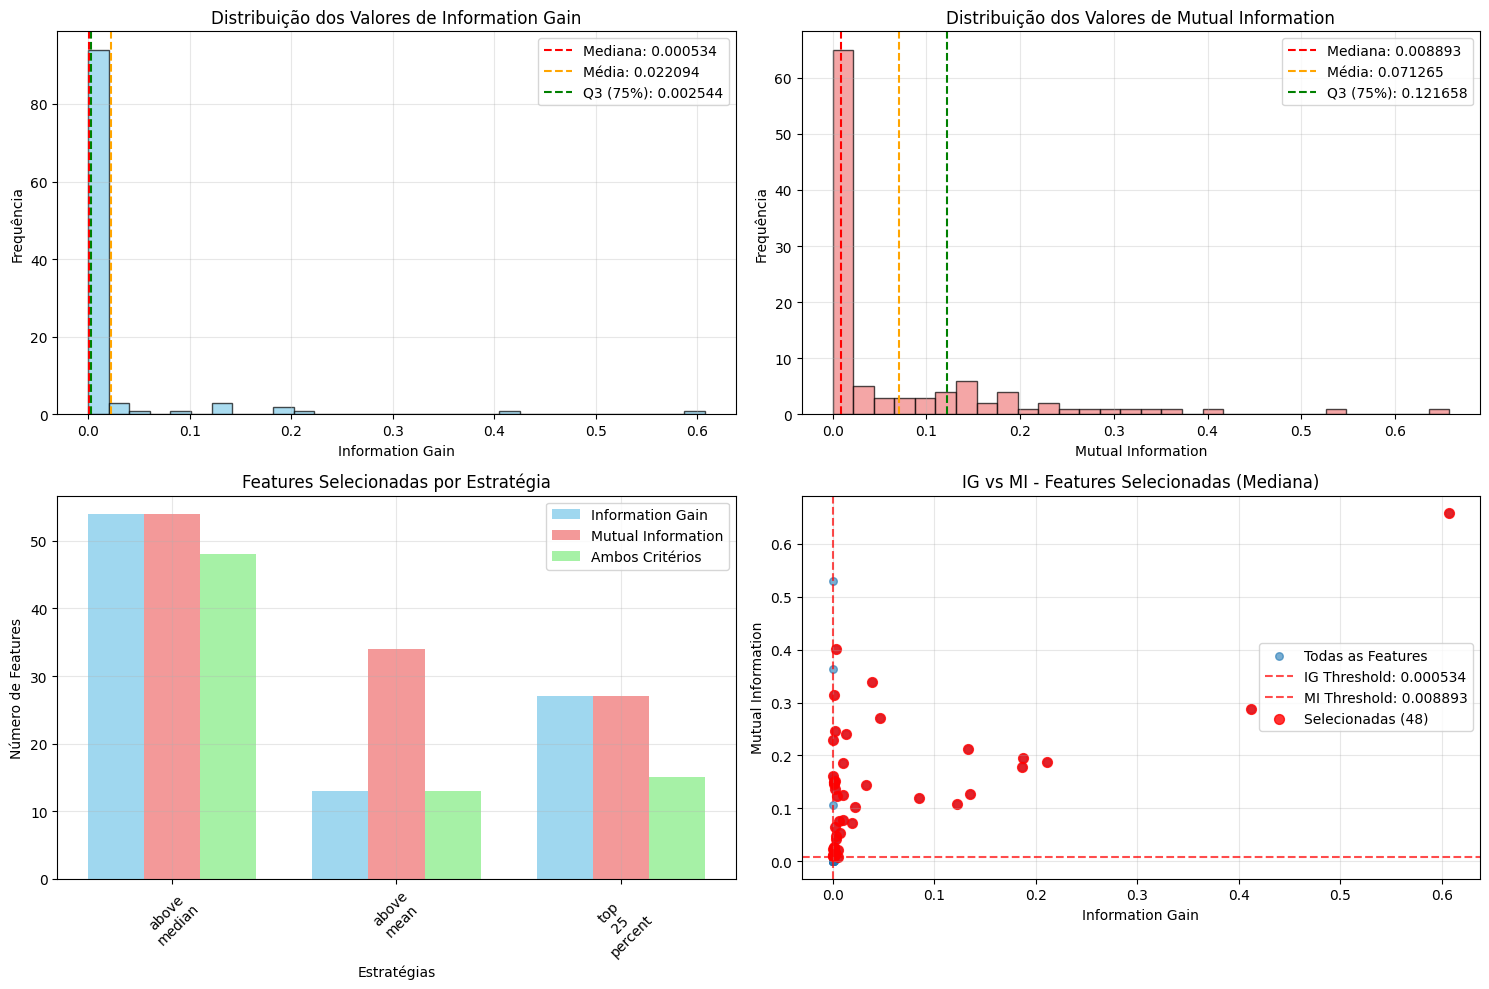


🔧 SELEÇÃO CUSTOMIZADA DE THRESHOLDS
Para usar thresholds customizados, modifique os valores abaixo:

# Exemplo de uso:
custom_ig_threshold = 0.01  # Seu threshold para Information Gain
custom_mi_threshold = 0.01  # Seu threshold para Mutual Information

# Aplicar seleção customizada:
custom_ig_selected = ig_results[ig_results['Information_Gain'] >= custom_ig_threshold]['Feature'].tolist()
custom_mi_selected = mi_results[mi_results['Mutual_Information'] >= custom_mi_threshold]['Feature'].tolist()
custom_both_criteria = list(set(custom_ig_selected) & set(custom_mi_selected))

print(f'Features selecionadas com thresholds customizados: {len(custom_both_criteria)}')

📊 INFORMAÇÕES DO COMBINED_RESULTS:
   • Shape: (107, 4)
   • Colunas: ['Feature', 'Information_Gain', 'Information_Gain_Ratio', 'Mutual_Information']
   • Features únicas: 107

   📋 Exemplo (primeiras 5 linhas):
                          Feature  Information_Gain  Information_Gain_Ratio  Mutual_Information
    mean_container_c

In [28]:
# Visualização dos Thresholds e Seleção Customizada
print("📊 Visualizando thresholds e permitindo seleção customizada...")

# Verificar se os resultados existem
if 'ig_results' in locals() and 'mi_results' in locals():
    
    # Primeiro, criar combined_results se não existir
    if 'combined_results' not in locals() or combined_results is None:
        print("🔄 Criando combined_results...")
        try:
            # Merge dos resultados de IG e MI
            combined_results = ig_results.merge(
                mi_results, 
                on='Feature', 
                how='outer', 
                suffixes=('_IG', '_MI')
            )
            print(f"✅ Combined_results criado com {len(combined_results)} features")
            
            # Calcular correlação entre as métricas
            if len(combined_results) > 1:
                correlation = combined_results['Information_Gain'].corr(
                    combined_results['Mutual_Information']
                )
                print(f"📊 Correlação IG vs MI: {correlation:.4f}")
            
        except Exception as e:
            print(f"❌ Erro ao criar combined_results: {e}")
            print("   Usando DataFrames separados para visualização")
            combined_results = None
    else:
        print(f"✅ Combined_results já existe com {len(combined_results)} features")
    
    # Criar visualização dos thresholds
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Subplot 1: Distribuição do Information Gain com thresholds
    axes[0, 0].hist(ig_results['Information_Gain'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(strategies['above_median']['ig_threshold'], color='red', linestyle='--', 
                       label=f"Mediana: {strategies['above_median']['ig_threshold']:.6f}")
    axes[0, 0].axvline(strategies['above_mean']['ig_threshold'], color='orange', linestyle='--',
                       label=f"Média: {strategies['above_mean']['ig_threshold']:.6f}")
    axes[0, 0].axvline(strategies['top_25_percent']['ig_threshold'], color='green', linestyle='--',
                       label=f"Q3 (75%): {strategies['top_25_percent']['ig_threshold']:.6f}")
    axes[0, 0].set_xlabel('Information Gain')
    axes[0, 0].set_ylabel('Frequência')
    axes[0, 0].set_title('Distribuição dos Valores de Information Gain')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Subplot 2: Distribuição do Mutual Information com thresholds
    axes[0, 1].hist(mi_results['Mutual_Information'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 1].axvline(strategies['above_median']['mi_threshold'], color='red', linestyle='--',
                       label=f"Mediana: {strategies['above_median']['mi_threshold']:.6f}")
    axes[0, 1].axvline(strategies['above_mean']['mi_threshold'], color='orange', linestyle='--',
                       label=f"Média: {strategies['above_mean']['mi_threshold']:.6f}")
    axes[0, 1].axvline(strategies['top_25_percent']['mi_threshold'], color='green', linestyle='--',
                       label=f"Q3 (75%): {strategies['top_25_percent']['mi_threshold']:.6f}")
    axes[0, 1].set_xlabel('Mutual Information')
    axes[0, 1].set_ylabel('Frequência')
    axes[0, 1].set_title('Distribuição dos Valores de Mutual Information')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Subplot 3: Número de features selecionadas por estratégia
    strategy_names = list(strategies.keys())
    ig_counts = [len(selection_results[s]['ig_selected']) for s in strategy_names]
    mi_counts = [len(selection_results[s]['mi_selected']) for s in strategy_names]
    both_counts = [len(selection_results[s]['both_criteria']) for s in strategy_names]
    
    x = np.arange(len(strategy_names))
    width = 0.25
    
    axes[1, 0].bar(x - width, ig_counts, width, label='Information Gain', alpha=0.8, color='skyblue')
    axes[1, 0].bar(x, mi_counts, width, label='Mutual Information', alpha=0.8, color='lightcoral')
    axes[1, 0].bar(x + width, both_counts, width, label='Ambos Critérios', alpha=0.8, color='lightgreen')
    
    axes[1, 0].set_xlabel('Estratégias')
    axes[1, 0].set_ylabel('Número de Features')
    axes[1, 0].set_title('Features Selecionadas por Estratégia')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels([s.replace('_', '\n') for s in strategy_names], rotation=45)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Subplot 4: Scatter plot IG vs MI com thresholds
    if combined_results is not None and not combined_results.empty:
        # Usar combined_results se disponível
        axes[1, 1].scatter(combined_results['Information_Gain'], combined_results['Mutual_Information'], 
                           alpha=0.6, s=30, label='Todas as Features')
        
        # Adicionar linhas de threshold da estratégia recomendada
        recommended_ig = strategies['above_median']['ig_threshold']
        recommended_mi = strategies['above_median']['mi_threshold']
        
        axes[1, 1].axvline(recommended_ig, color='red', linestyle='--', alpha=0.7, 
                          label=f'IG Threshold: {recommended_ig:.6f}')
        axes[1, 1].axhline(recommended_mi, color='red', linestyle='--', alpha=0.7, 
                          label=f'MI Threshold: {recommended_mi:.6f}')
        
        # Destacar features selecionadas
        selected_features = recommended['both_criteria']
        if len(selected_features) > 0:
            selected_data = combined_results[combined_results['Feature'].isin(selected_features)]
            if not selected_data.empty:
                axes[1, 1].scatter(selected_data['Information_Gain'], selected_data['Mutual_Information'], 
                                  color='red', s=50, alpha=0.8, label=f'Selecionadas ({len(selected_features)})')
        
        axes[1, 1].set_xlabel('Information Gain')
        axes[1, 1].set_ylabel('Mutual Information')
        axes[1, 1].set_title('IG vs MI - Features Selecionadas (Mediana)')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
    else:
        # Fallback: usar apenas dados dos DataFrames originais sem merge
        print("⚠️ Combined_results não disponível, usando gráfico alternativo...")
        
        # Criar scatter plot usando os índices das features
        ig_values = ig_results['Information_Gain'].values
        mi_values = [mi_results[mi_results['Feature'] == feat]['Mutual_Information'].iloc[0] 
                    if feat in mi_results['Feature'].values else 0 
                    for feat in ig_results['Feature'].values]
        
        axes[1, 1].scatter(ig_values, mi_values, alpha=0.6, s=30, label='Features')
        
        # Adicionar thresholds
        recommended_ig = strategies['above_median']['ig_threshold']
        recommended_mi = strategies['above_median']['mi_threshold']
        
        axes[1, 1].axvline(recommended_ig, color='red', linestyle='--', alpha=0.7, 
                          label=f'IG Threshold: {recommended_ig:.6f}')
        axes[1, 1].axhline(recommended_mi, color='red', linestyle='--', alpha=0.7, 
                          label=f'MI Threshold: {recommended_mi:.6f}')
        
        axes[1, 1].set_xlabel('Information Gain')
        axes[1, 1].set_ylabel('Mutual Information')
        axes[1, 1].set_title('IG vs MI - Dados Separados')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70)
    print("🔧 SELEÇÃO CUSTOMIZADA DE THRESHOLDS")
    print("="*70)
    print("Para usar thresholds customizados, modifique os valores abaixo:")
    print()
    print("# Exemplo de uso:")
    print("custom_ig_threshold = 0.01  # Seu threshold para Information Gain")
    print("custom_mi_threshold = 0.01  # Seu threshold para Mutual Information")
    print()
    print("# Aplicar seleção customizada:")
    print("custom_ig_selected = ig_results[ig_results['Information_Gain'] >= custom_ig_threshold]['Feature'].tolist()")
    print("custom_mi_selected = mi_results[mi_results['Mutual_Information'] >= custom_mi_threshold]['Feature'].tolist()")
    print("custom_both_criteria = list(set(custom_ig_selected) & set(custom_mi_selected))")
    print()
    print("print(f'Features selecionadas com thresholds customizados: {len(custom_both_criteria)}')")
    
    # Mostrar informações sobre combined_results se foi criado
    if 'combined_results' in locals() and combined_results is not None:
        print(f"\n📊 INFORMAÇÕES DO COMBINED_RESULTS:")
        print(f"   • Shape: {combined_results.shape}")
        print(f"   • Colunas: {list(combined_results.columns)}")
        print(f"   • Features únicas: {combined_results['Feature'].nunique()}")
        if len(combined_results) > 0:
            print(f"\n   📋 Exemplo (primeiras 5 linhas):")
            print(combined_results.head().to_string(index=False, max_cols=4))
    
else:
    print("❌ Execute primeiro as células de cálculo de IG e MI!")
    print("   Células necessárias:")
    print("   • Cálculo de Information Gain")
    print("   • Cálculo de Mutual Information")
    print("   • Definição de estratégias de seleção")

In [29]:
# Combina os resultados para comparação
try:
    # Merge dos resultados
    combined_results = ig_results.merge(
        mi_results, 
        on='Feature', 
        how='outer', 
        suffixes=('_IG', '_MI')
    )
    
    print("Comparação entre Information Gain e Mutual Information:")
    print("="*70)
    print(combined_results.head(15))
    
    # Calcula correlação entre as métricas
    if len(combined_results) > 1:
        correlation = combined_results['Information_Gain'].corr(
            combined_results['Mutual_Information']
        )
        print(f"\nCorrelação entre Information Gain e Mutual Information: {correlation:.4f}")
    
except Exception as e:
    print(f"Erro ao combinar resultados: {e}")
    print("\nResultados separados:")
    print("\nInformation Gain:")
    if 'ig_results' in locals():
        print(ig_results.head(10))
    print("\nMutual Information:")
    if 'mi_results' in locals():
        print(mi_results.head(10))

Comparação entre Information Gain e Mutual Information:
                              Feature  Information_Gain  \
0       mean_container_cpu_nr_periods          0.000000   
1     mean_container_cpu_nr_throttled          0.000000   
2           mean_container_cpu_system          0.003258   
3   mean_container_cpu_throttled_time          0.000000   
4             mean_container_cpu_user          0.003533   
5       mean_container_disk_8:0_async          0.000607   
6     mean_container_disk_8:0_discard          0.000000   
7        mean_container_disk_8:0_read          0.001317   
8      mean_container_mem_active_anon          0.002628   
9      mean_container_mem_active_file          0.001302   
10           mean_container_mem_cache          0.000620   
11   mean_container_mem_inactive_anon          0.001263   
12   mean_container_mem_inactive_file          0.001351   
13     mean_container_mem_mapped_file          0.004915   
14         mean_container_mem_pgfault          0.002143   


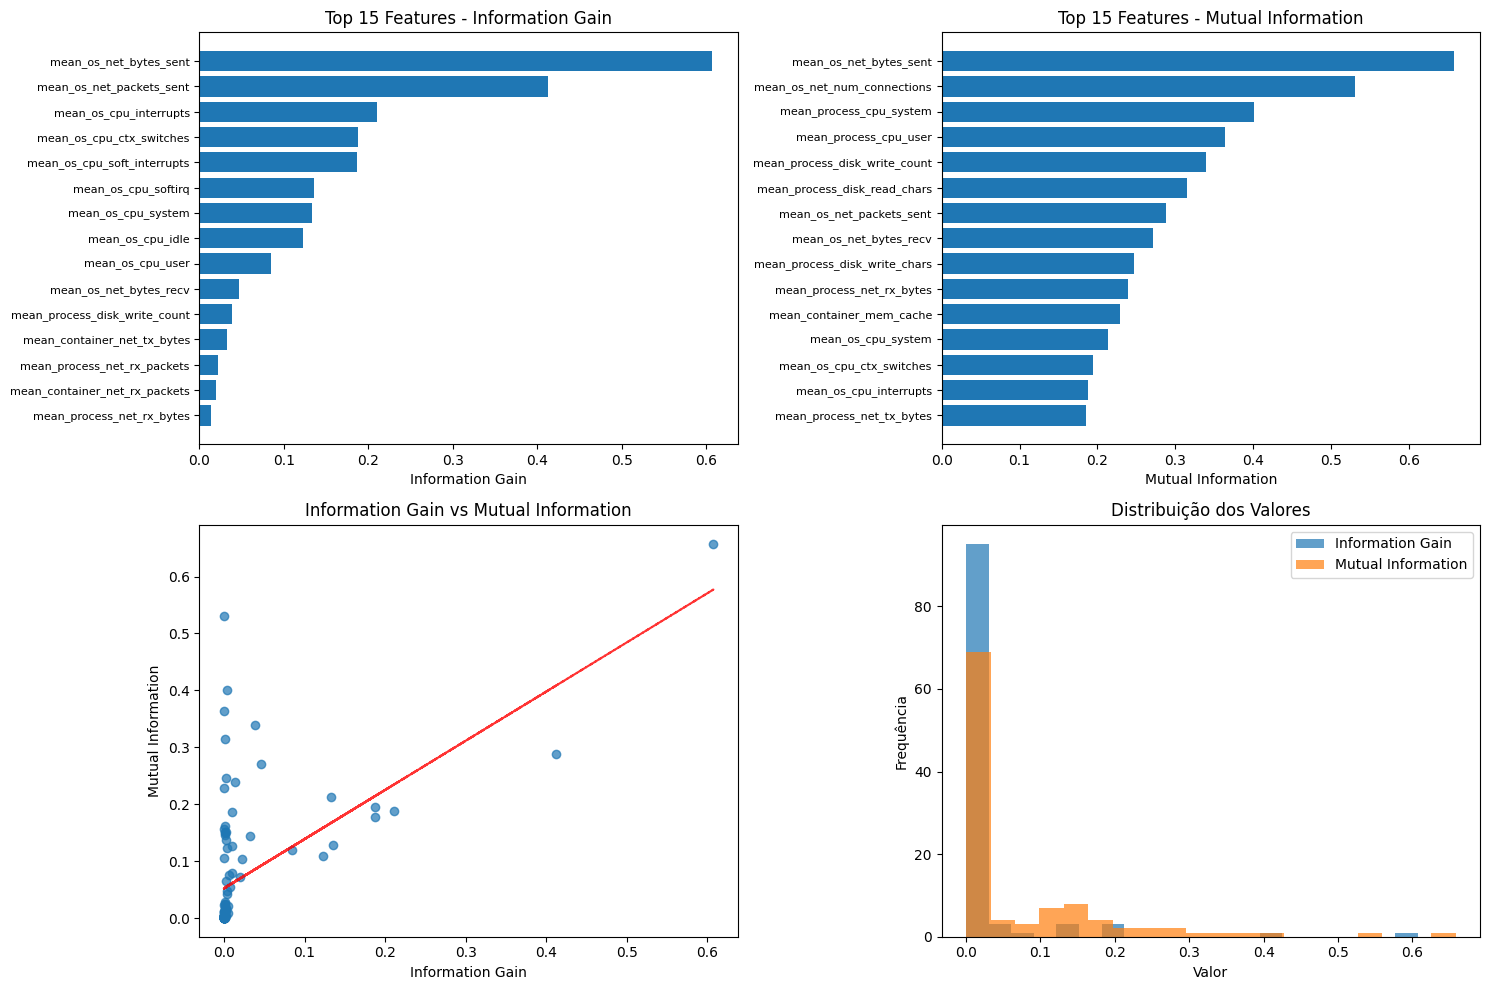

In [30]:
# Visualizações
plt.figure(figsize=(15, 10))

# Subplot 1: Top 15 features por Information Gain
plt.subplot(2, 2, 1)
if 'ig_results' in locals() and len(ig_results) > 0:
    top_ig = ig_results.head(15)
    plt.barh(range(len(top_ig)), top_ig['Information_Gain'])
    plt.yticks(range(len(top_ig)), top_ig['Feature'], fontsize=8)
    plt.xlabel('Information Gain')
    plt.title('Top 15 Features - Information Gain')
    plt.gca().invert_yaxis()

# Subplot 2: Top 15 features por Mutual Information
plt.subplot(2, 2, 2)
if 'mi_results' in locals() and len(mi_results) > 0:
    top_mi = mi_results.head(15)
    plt.barh(range(len(top_mi)), top_mi['Mutual_Information'])
    plt.yticks(range(len(top_mi)), top_mi['Feature'], fontsize=8)
    plt.xlabel('Mutual Information')
    plt.title('Top 15 Features - Mutual Information')
    plt.gca().invert_yaxis()

# Subplot 3: Correlação entre IG e MI (se disponível)
plt.subplot(2, 2, 3)
try:
    if 'combined_results' in locals() and len(combined_results) > 1:
        plt.scatter(combined_results['Information_Gain'], 
                   combined_results['Mutual_Information'], 
                   alpha=0.7)
        plt.xlabel('Information Gain')
        plt.ylabel('Mutual Information')
        plt.title('Information Gain vs Mutual Information')
        
        # Adiciona linha de tendência
        z = np.polyfit(combined_results['Information_Gain'].fillna(0), 
                      combined_results['Mutual_Information'].fillna(0), 1)
        p = np.poly1d(z)
        plt.plot(combined_results['Information_Gain'].fillna(0), 
                p(combined_results['Information_Gain'].fillna(0)), 
                "r--", alpha=0.8)
    else:
        plt.text(0.5, 0.5, 'Dados não disponíveis\npara correlação', 
                ha='center', va='center', transform=plt.gca().transAxes)
except Exception as e:
    plt.text(0.5, 0.5, f'Erro: {str(e)[:50]}...', 
            ha='center', va='center', transform=plt.gca().transAxes)

# Subplot 4: Distribuição dos valores
plt.subplot(2, 2, 4)
try:
    if 'ig_results' in locals() and 'mi_results' in locals():
        plt.hist(ig_results['Information_Gain'], alpha=0.7, label='Information Gain', bins=20)
        plt.hist(mi_results['Mutual_Information'], alpha=0.7, label='Mutual Information', bins=20)
        plt.xlabel('Valor')
        plt.ylabel('Frequência')
        plt.title('Distribuição dos Valores')
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Dados não disponíveis', 
                ha='center', va='center', transform=plt.gca().transAxes)
except Exception as e:
    plt.text(0.5, 0.5, f'Erro: {str(e)[:50]}...', 
            ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

## Salvando os Resultados

## Interpretação dos Resultados

### Information Gain vs Mutual Information

**Information Gain:**
- Mede a redução na entropia quando dividimos o dataset por um atributo
- Valores mais altos indicam maior capacidade de discriminação
- Favorece atributos com mais valores únicos (pode ter viés)

**Mutual Information:**
- Mede a dependência estatística entre variáveis
- Mais robusto para diferentes tipos de variáveis
- Não favorece atributos com mais valores únicos

### Como usar os resultados:
1. **Seleção de Features**: Use as features com maior IG ou MI para modelos de ML
2. **Feature Engineering**: Combine ou transforme features com baixo IG/MI
3. **Análise Exploratória**: Entenda quais variáveis são mais informativas
4. **Redução de Dimensionalidade**: Mantenha apenas as features mais importantes

=== RESULTADOS DO GANHO DE INFORMAÇÃO ===

🏆 TOP 20 FEATURES - INFORMAÇÃO MÚTUA:
 1. mean_os_net_bytes_sent                             | MI: 0.657883
 2. mean_os_net_num_connections                        | MI: 0.529928
 3. mean_process_cpu_system                            | MI: 0.401139
 4. mean_process_cpu_user                              | MI: 0.363641
 5. mean_process_disk_write_count                      | MI: 0.338784
 6. mean_process_disk_read_chars                       | MI: 0.314630
 7. mean_os_net_packets_sent                           | MI: 0.287810
 8. mean_os_net_bytes_recv                             | MI: 0.270781
 9. mean_process_disk_write_chars                      | MI: 0.246426
10. mean_process_net_rx_bytes                          | MI: 0.239660
11. mean_container_mem_cache                           | MI: 0.228949
12. mean_os_cpu_system                                 | MI: 0.212864
13. mean_os_cpu_ctx_switches                           | MI: 0.194604
14. mean_

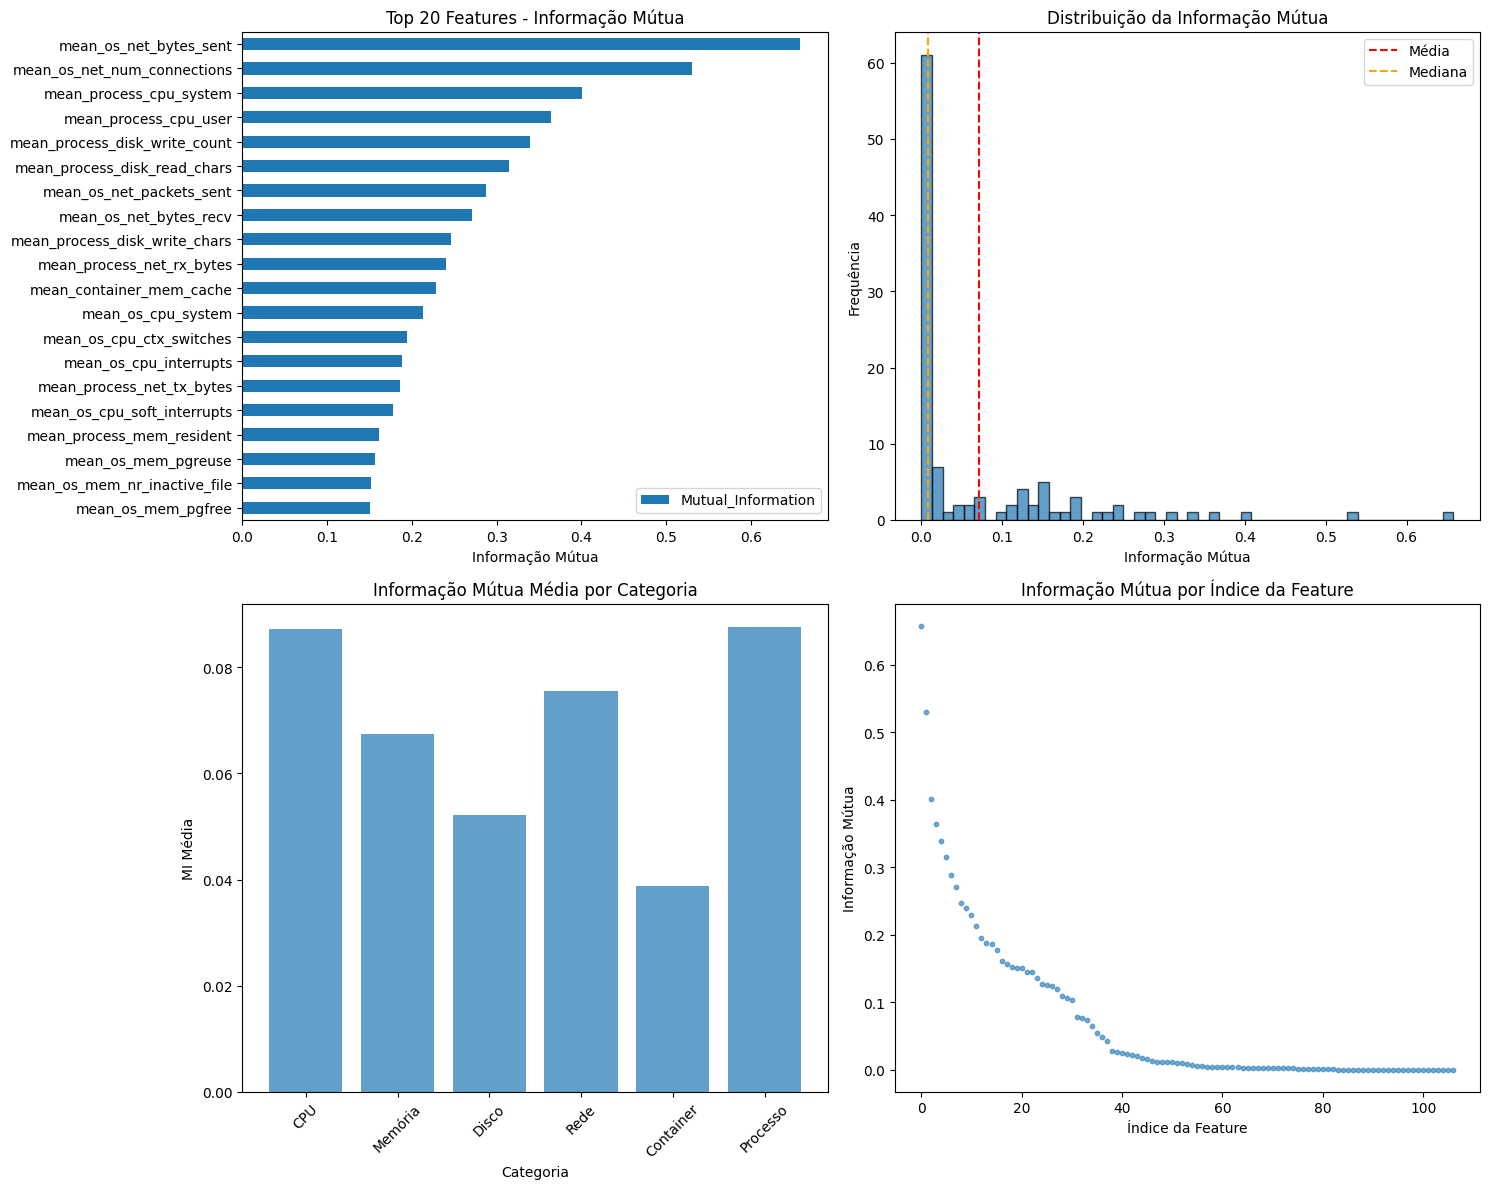

In [31]:
# Análise e visualização dos resultados
target_column = 'target'  # Substitua pelo nome real da coluna alvo
if target_column is not None and 'mi_results' in locals() and mi_results is not None:
    
    print("=== RESULTADOS DO GANHO DE INFORMAÇÃO ===")
    
    # Top 20 features com maior informação mútua
    print("\n🏆 TOP 20 FEATURES - INFORMAÇÃO MÚTUA:")
    top_20_mi = mi_results.head(20)
    for i, (_, row) in enumerate(top_20_mi.iterrows(), 1):
        print(f"{i:2d}. {row['Feature']:<50} | MI: {row['Mutual_Information']:.6f}")
    
    # Estatísticas gerais
    print(f"\n📊 ESTATÍSTICAS GERAIS:")
    print(f"• Total de features analisadas: {len(mi_results)}")
    print(f"• Informação Mútua média: {mi_results['Mutual_Information'].mean():.6f}")
    print(f"• Informação Mútua mediana: {mi_results['Mutual_Information'].median():.6f}")
    print(f"• Desvio padrão: {mi_results['Mutual_Information'].std():.6f}")
    print(f"• Features com MI > 0.01: {(mi_results['Mutual_Information'] > 0.01).sum()}")
    print(f"• Features com MI > 0.1: {(mi_results['Mutual_Information'] > 0.1).sum()}")
    
    # Visualizações
    plt.figure(figsize=(15, 12))
    
    # 1. Top 20 features
    plt.subplot(2, 2, 1)
    top_20_mi.plot(x='Feature', y='Mutual_Information', kind='barh', ax=plt.gca())
    plt.title('Top 20 Features - Informação Mútua')
    plt.xlabel('Informação Mútua')
    plt.ylabel('')
    plt.gca().invert_yaxis()
    
    # 2. Distribuição dos valores de MI
    plt.subplot(2, 2, 2)
    plt.hist(mi_results['Mutual_Information'], bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(mi_results['Mutual_Information'].mean(), color='red', linestyle='--', label='Média')
    plt.axvline(mi_results['Mutual_Information'].median(), color='orange', linestyle='--', label='Mediana')
    plt.title('Distribuição da Informação Mútua')
    plt.xlabel('Informação Mútua')
    plt.ylabel('Frequência')
    plt.legend()
    
    # 3. Análise por categoria de métrica
    print(f"\n📋 ANÁLISE POR CATEGORIA:")
    
    categorias = {
        'CPU': [col for col in mi_results['Feature'] if 'cpu' in col.lower()],
        'Memória': [col for col in mi_results['Feature'] if 'mem' in col.lower()],
        'Disco': [col for col in mi_results['Feature'] if 'disk' in col.lower()],
        'Rede': [col for col in mi_results['Feature'] if 'net' in col.lower()],
        'Container': [col for col in mi_results['Feature'] if 'container' in col.lower()],
        'Processo': [col for col in mi_results['Feature'] if 'process' in col.lower()]
    }
    
    categoria_scores = {}
    for categoria, features_cat in categorias.items():
        if features_cat:
            scores = mi_results[mi_results['Feature'].isin(features_cat)]['Mutual_Information']
            categoria_scores[categoria] = {
                'count': len(scores),
                'mean': scores.mean(),
                'max': scores.max(),
                'top_feature': mi_results[mi_results['Feature'].isin(features_cat)].iloc[0]['Feature'] if len(scores) > 0 else 'N/A'
            }
            print(f"• {categoria}: {len(scores)} features | Média MI: {scores.mean():.6f} | Max: {scores.max():.6f}")
    
    # 4. MI por categoria
    plt.subplot(2, 2, 3)
    if categoria_scores:
        cats = list(categoria_scores.keys())
        means = [categoria_scores[cat]['mean'] for cat in cats]
        plt.bar(cats, means, alpha=0.7)
        plt.title('Informação Mútua Média por Categoria')
        plt.xlabel('Categoria')
        plt.ylabel('MI Média')
        plt.xticks(rotation=45)
    
    # 5. Scatter plot: MI vs Feature Index
    plt.subplot(2, 2, 4)
    plt.scatter(range(len(mi_results)), mi_results['Mutual_Information'], alpha=0.6, s=10)
    plt.title('Informação Mútua por Índice da Feature')
    plt.xlabel('Índice da Feature')
    plt.ylabel('Informação Mútua')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Resultados não disponíveis para visualização")

## 🚀 Aplicação Prática das Features Selecionadas

Esta seção demonstra como aplicar os resultados da análise de ganho de informação e mutual information na prática, criando datasets reduzidos e fornecendo exemplos de uso em Machine Learning.

In [32]:
# 1. Criação de Datasets Reduzidos com Features Selecionadas
print("📊 CRIAÇÃO DE DATASETS REDUZIDOS")
print("="*70)

# Verificar se os resultados necessários existem
required_vars = ['ig_results', 'mi_results', 'selection_results']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"❌ Variáveis necessárias não encontradas: {missing_vars}")
    print("   Execute primeiro as células de análise de ganho de informação!")
else:
    print("✅ Todas as variáveis necessárias encontradas!")
    
    # Usar estratégia recomendada (acima da mediana)
    if 'selection_results' in globals() and 'above_median' in selection_results:
        selected_features = selection_results['above_median']['both_criteria']
        strategy_used = 'above_median'
    else:
        # Fallback: usar top 25% das features por MI
        print("⚠️ Usando estratégia de fallback: top 25% por Mutual Information")
        top_25_count = max(1, len(mi_results) // 4)  # Pelo menos 1 feature
        selected_features = mi_results.head(top_25_count)['Feature'].tolist()
        strategy_used = 'top_25_percent_mi'
    
    print(f"\n🎯 Estratégia utilizada: {strategy_used}")
    print(f"📊 Features selecionadas: {len(selected_features)}")
    print(f"📊 Features originais: {X.shape[1]}")
    print(f"📉 Redução: {(1 - len(selected_features)/X.shape[1])*100:.1f}%")
    
    # Criar datasets reduzidos
    if len(selected_features) > 0:
        print(f"\n🔨 Criando datasets reduzidos...")
        
        # Dataset principal reduzido
        X_selected = X[selected_features].copy()
        
        # Datasets de treinamento reduzidos
        if isinstance(X_train, pd.DataFrame):
            # Se X_train é DataFrame
            available_features = [f for f in selected_features if f in X_train.columns]
            X_train_selected = X_train[available_features].copy()
            X_test_selected = X_test[available_features].copy() if 'X_test' in globals() else None
            X_val_selected = X_val[available_features].copy() if 'X_val' in globals() else None
        else:
            # Se X_train é numpy array, usar índices
            if hasattr(X, 'columns'):
                feature_indices = [i for i, col in enumerate(X.columns) if col in selected_features]
                X_train_selected = X_train[:, feature_indices]
                X_test_selected = X_test[:, feature_indices] if 'X_test' in globals() else None
                X_val_selected = X_val[:, feature_indices] if 'X_val' in globals() else None
            else:
                print("⚠️ Não foi possível criar versões numpy dos datasets de treino")
                X_train_selected = None
                X_test_selected = None
                X_val_selected = None
        
        print(f"✅ Datasets reduzidos criados:")
        print(f"   • X_selected shape: {X_selected.shape}")
        if X_train_selected is not None:
            print(f"   • X_train_selected shape: {X_train_selected.shape}")
        if X_test_selected is not None:
            print(f"   • X_test_selected shape: {X_test_selected.shape}")
        if X_val_selected is not None:
            print(f"   • X_val_selected shape: {X_val_selected.shape}")
        
        # Criar summary das features selecionadas
        print(f"\n📋 Criando summary das features selecionadas...")
        selected_summary_data = []
        
        for feature in selected_features:
            # Obter scores de IG e MI
            ig_score = ig_results[ig_results['Feature'] == feature]['Information_Gain'].iloc[0] if feature in ig_results['Feature'].values else 0
            mi_score = mi_results[mi_results['Feature'] == feature]['Mutual_Information'].iloc[0] if feature in mi_results['Feature'].values else 0
            
            selected_summary_data.append({
                'Feature': feature,
                'Information_Gain': ig_score,
                'Mutual_Information': mi_score,
                'Rank_IG': ig_results[ig_results['Feature'] == feature].index[0] + 1 if feature in ig_results['Feature'].values else len(ig_results) + 1,
                'Rank_MI': mi_results[mi_results['Feature'] == feature].index[0] + 1 if feature in mi_results['Feature'].values else len(mi_results) + 1
            })
        
        selected_features_summary = pd.DataFrame(selected_summary_data)
        selected_features_summary = selected_features_summary.sort_values('Information_Gain', ascending=False)
        
        print(f"✅ Summary criado com {len(selected_features_summary)} features")
        
        # Mostrar top 10 features selecionadas
        print(f"\n🏆 TOP 10 FEATURES SELECIONADAS:")
        print("-" * 70)
        for idx, row in selected_features_summary.head(10).iterrows():
            print(f"   {row['Rank_IG']:2d}. {row['Feature']:30s} | IG: {row['Information_Gain']:.6f} | MI: {row['Mutual_Information']:.6f}")
        
        # Salvar no ambiente global
        globals()['X_selected'] = X_selected
        globals()['selected_features_list'] = selected_features
        selected_features_list = selected_features  # Para exibição
        globals()['selected_features_summary'] = selected_features_summary
        if X_train_selected is not None:
            globals()['X_train_selected'] = X_train_selected
        if X_test_selected is not None:
            globals()['X_test_selected'] = X_test_selected
        if X_val_selected is not None:
            globals()['X_val_selected'] = X_val_selected
        
        print(f"\n💾 Variáveis criadas no ambiente:")
        print(f"   • X_selected: Dataset principal com features selecionadas")
        print(f"   • selected_features_list: Lista das features selecionadas")
        print(f"   • selected_features_summary: DataFrame com rankings e scores")
        if X_train_selected is not None:
            print(f"   • X_train_selected, X_test_selected, X_val_selected: Conjuntos de treino/teste/validação")
        
    else:
        print("❌ Nenhuma feature selecionada! Verifique os thresholds utilizados.")



📊 CRIAÇÃO DE DATASETS REDUZIDOS
✅ Todas as variáveis necessárias encontradas!

🎯 Estratégia utilizada: above_median
📊 Features selecionadas: 48
📊 Features originais: 107
📉 Redução: 55.1%

🔨 Criando datasets reduzidos...
✅ Datasets reduzidos criados:
   • X_selected shape: (32259, 48)
   • X_train_selected shape: (32259, 48)
   • X_test_selected shape: (24194, 48)
   • X_val_selected shape: (24195, 48)

📋 Criando summary das features selecionadas...
✅ Summary criado com 48 features

🏆 TOP 10 FEATURES SELECIONADAS:
----------------------------------------------------------------------
   40. mean_os_net_bytes_sent         | IG: 0.607395 | MI: 0.657883
   46. mean_os_net_packets_sent       | IG: 0.412268 | MI: 0.287810
    5. mean_os_cpu_interrupts         | IG: 0.210774 | MI: 0.187693
    1. mean_os_cpu_ctx_switches       | IG: 0.187970 | MI: 0.194604
    9. mean_os_cpu_soft_interrupts    | IG: 0.186976 | MI: 0.177362
   10. mean_os_cpu_softirq            | IG: 0.135683 | MI: 0.127546
  

In [19]:
# 2. Salvamento de Arquivos
print("\n💾 SALVAMENTO DE ARQUIVOS")
print("="*70)

if 'selected_features_list' in globals() and len(selected_features_list) > 0:
    try:
        import os
        import pickle
        
        # Criar diretório se não existir
        output_dir = '../dataset'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"📁 Diretório criado: {output_dir}")
        
        # 1. Salvar lista de features selecionadas (selected_features.txt)
        features_file = os.path.join(output_dir, 'selected_features.txt')
        with open(features_file, 'w', encoding='utf-8') as f:
            f.write(f"# Features Selecionadas - Análise de Ganho de Informação\n")
            f.write(f"# Data: {pd.Timestamp.now()}\n")
            f.write(f"# Estratégia: {strategy_used}\n")
            f.write(f"# Total de features: {len(selected_features_list)}\n")
            f.write(f"# Redução: {(1 - len(selected_features_list)/X.shape[1])*100:.1f}%\n")
            f.write(f"#\n")
            for i, feature in enumerate(selected_features_list, 1):
                f.write(f"{feature}\n")
        
        print(f"✅ {features_file}")
        print(f"   • {len(selected_features_list)} features salvas")
        
        # 2. Salvar dataset reduzido completo em pickle
        if 'X_selected' in globals():
            dataset_pickle_file = os.path.join(output_dir, f'{nome_dataset}_selected_datasets.pkl')
            
            # Criar dicionário com todos os datasets selecionados
            selected_data = {
                'X_selected': X_selected,
                'y_selected' : y,
                'selected_features_list': selected_features_list,
                'selected_features_summary': selected_features_summary if 'selected_features_summary' in globals() else None,
                'strategy_used': strategy_used,
                'creation_date': pd.Timestamp.now(),
                'original_shape': X.shape,
                'selected_shape': X_selected.shape,
                'reduction_percentage': (1 - len(selected_features_list)/X.shape[1])*100
            }
            
            # Adicionar conjuntos de treino/teste/validação se disponíveis
            if 'X_train_selected' in globals() and X_train_selected is not None:
                selected_data['X_train_selected'] = X_train_selected
            if 'X_test_selected' in globals() and X_test_selected is not None:
                selected_data['X_test_selected'] = X_test_selected
            if 'X_val_selected' in globals() and X_val_selected is not None:
                selected_data['X_val_selected'] = X_val_selected
            
            # Adicionar targets se disponíveis no ambiente global
            if 'y_train' in globals():
                selected_data['y_train'] = y_train
            if 'y_test' in globals():
                selected_data['y_test'] = y_test
            if 'y_val' in globals():
                selected_data['y_val'] = y_val
            if 'y' in globals():
                selected_data['y'] = y
            
            # Salvar em pickle
            with open(dataset_pickle_file, 'wb') as f:
                pickle.dump(selected_data, f)
            print(f"✅ {dataset_pickle_file}")
            print(f"   • Shape: {X_selected.shape}")
            print(f"   • Tamanho: {os.path.getsize(dataset_pickle_file) / (1024*1024):.2f} MB")
            print(f"   • Conteúdo: {len(selected_data)} objetos salvos")
        
        # 3. Salvar summary com scores em pickle separado
        if 'selected_features_summary' in globals():
            summary_pickle_file = os.path.join(output_dir, f'{nome_dataset}_selected_features_summary.pkl')
            with open(summary_pickle_file, 'wb') as f:
                pickle.dump(selected_features_summary, f)
            print(f"✅ {summary_pickle_file}")
            print(f"   • {len(selected_features_summary)} features com scores e rankings")
        
        # 4. Listar conjuntos salvos no pickle principal
        saved_datasets = []
        if 'X_train_selected' in globals() and X_train_selected is not None:
            saved_datasets.append(f"X_train_selected ({X_train_selected.shape})")
        if 'X_test_selected' in globals() and X_test_selected is not None:
            saved_datasets.append(f"X_test_selected ({X_test_selected.shape})")
        if 'X_val_selected' in globals() and X_val_selected is not None:
            saved_datasets.append(f"X_val_selected ({X_val_selected.shape})")
        
        if saved_datasets:
            print(f"✅ Conjuntos treino/teste/validação (no pickle principal):")
            for dataset_info in saved_datasets:
                print(f"   • {dataset_info}")
        
        # 5. Criar arquivo README com informações atualizadas
        readme_file = os.path.join(output_dir, f'{nome_dataset}_README_selected_features.md')
        with open(readme_file, 'w', encoding='utf-8') as f:
            f.write("# Features Selecionadas - Análise de Ganho de Informação\n\n")
            f.write(f"**Data de criação:** {pd.Timestamp.now()}\n\n")
            f.write(f"**Estratégia utilizada:** {strategy_used}\n\n")
            f.write(f"## Resumo\n\n")
            f.write(f"- **Features originais:** {X.shape[1]}\n")
            f.write(f"- **Features selecionadas:** {len(selected_features_list)}\n")
            f.write(f"- **Redução:** {(1 - len(selected_features_list)/X.shape[1])*100:.1f}%\n\n")
            
            f.write(f"## Arquivos Gerados\n\n")
            f.write(f"1. **selected_features.txt** - Lista simples das features selecionadas\n")
            f.write(f"2. **selected_datasets.pkl** - Arquivo pickle com todos os datasets reduzidos e metadados\n")
            f.write(f"3. **selected_features_summary.pkl** - Scores e rankings detalhados das features (pickle)\n")
            f.write(f"4. **README_selected_features.md** - Este arquivo de documentação\n")
            
            f.write(f"\n## Conteúdo do Arquivo Pickle Principal\n\n")
            f.write(f"O arquivo `selected_datasets.pkl` contém:\n")
            f.write(f"- **X_selected**: Dataset principal com features selecionadas\n")
            f.write(f"- **selected_features_list**: Lista das features selecionadas\n")
            f.write(f"- **selected_features_summary**: DataFrame com scores e rankings\n")
            if saved_datasets:
                f.write(f"- **Conjuntos treino/teste/validação**: Versões reduzidas dos conjuntos\n")
            f.write(f"- **Metadados**: Estratégia usada, data de criação, informações de redução\n")
            
            f.write(f"\n## Top 10 Features\n\n")
            f.write(f"| Rank | Feature | Information Gain | Mutual Information |\n")
            f.write(f"|------|---------|------------------|--------------------|\n")
            if 'selected_features_summary' in globals():
                for idx, row in selected_features_summary.head(10).iterrows():
                    f.write(f"| {row['Rank_IG']:2d} | {row['Feature']} | {row['Information_Gain']:.6f} | {row['Mutual_Information']:.6f} |\n")
            
            f.write(f"\n## Como Usar\n\n")
            f.write(f"```python\n")
            f.write(f"import pandas as pd\n")
            f.write(f"import numpy as np\n")
            f.write(f"import pickle\n\n")
            f.write(f"# Carregar features selecionadas (texto)\n")
            f.write(f"with open('selected_features.txt', 'r') as f:\n")
            f.write(f"    selected_features = [line.strip() for line in f if not line.startswith('#') and line.strip()]\n\n")
            f.write(f"# Carregar todos os datasets e metadados (pickle)\n")
            f.write(f"with open('selected_datasets.pkl', 'rb') as f:\n")
            f.write(f"    data = pickle.load(f)\n\n")
            f.write(f"# Acessar datasets\n")
            f.write(f"X_selected = data['X_selected']\n")
            f.write(f"selected_features = data['selected_features_list']\n")
            f.write(f"summary = data['selected_features_summary']\n\n")
            f.write(f"# Acessar conjuntos de treino/teste (se disponíveis)\n")
            f.write(f"if 'X_train_selected' in data:\n")
            f.write(f"    X_train_selected = data['X_train_selected']\n")
            f.write(f"    y_train = data.get('y_train', None)\n\n")
            f.write(f"# Carregar summary separado (pickle)\n")
            f.write(f"with open('selected_features_summary.pkl', 'rb') as f:\n")
            f.write(f"    summary_df = pickle.load(f)\n")
            f.write(f"```\n")
        
        print(f"✅ {readme_file}")
        print(f"   • Documentação completa criada")
        
        print(f"\n📊 RESUMO DE ARQUIVOS SALVOS:")
        print(f"   • Total de arquivos: 4 (TXT + PKL principal + PKL summary + README)")
        print(f"   • Formato principal: Pickle (mais eficiente e preserva tipos)")
        print(f"   • Diretório: {os.path.abspath(output_dir)}")
        
        print(f"\n🔍 VANTAGENS DO FORMATO PICKLE:")
        print(f"   • Preserva tipos de dados originais (DataFrame, numpy arrays)")
        print(f"   • Carregamento mais rápido que CSV")
        print(f"   • Menor tamanho de arquivo")
        print(f"   • Suporte nativo a objetos Python complexos")
        print(f"   • Metadados incluídos no mesmo arquivo")
        
    except Exception as e:
        print(f"❌ Erro ao salvar arquivos: {e}")
        print(f"   Verifique permissões de escrita no diretório {output_dir}")

else:
    print("❌ Nenhuma feature selecionada para salvar!")


💾 SALVAMENTO DE ARQUIVOS
✅ ../dataset\selected_features.txt
   • 48 features salvas
✅ ../dataset\svm_selected_datasets.pkl
   • Shape: (32259, 48)
   • Tamanho: 42.83 MB
   • Conteúdo: 16 objetos salvos
✅ ../dataset\svm_selected_features_summary.pkl
   • 48 features com scores e rankings
✅ Conjuntos treino/teste/validação (no pickle principal):
   • X_train_selected ((32259, 48))
   • X_test_selected ((24194, 48))
   • X_val_selected ((24195, 48))
✅ ../dataset\svm_README_selected_features.md
   • Documentação completa criada

📊 RESUMO DE ARQUIVOS SALVOS:
   • Total de arquivos: 4 (TXT + PKL principal + PKL summary + README)
   • Formato principal: Pickle (mais eficiente e preserva tipos)
   • Diretório: c:\Users\cpires\OneDrive - STJ- Superior Tribunal de Justiça\AIA\Cursos\Mestrado\Projeto Final\analise_kubemon\dataset

🔍 VANTAGENS DO FORMATO PICKLE:
   • Preserva tipos de dados originais (DataFrame, numpy arrays)
   • Carregamento mais rápido que CSV
   • Menor tamanho de arquivo
  

In [33]:
"""
# 2. Atualizar dataset pickle original com datasets reduzidos
print("\n💾 ATUALIZAÇÃO DO DATASET PICKLE ORIGINAL")
# 
            
with open(arq_dataset_pkl, 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'X_test': X_test,
        'X_val': X_val,
        'y_train': y_train,
        'y_test': y_test,
        'y_val': y_val,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'X_val_scaled': X_val_scaled,
        'yeo_johnson_transformer': datasets['yeo_johnson_transformer'] if 'yeo_johnson_transformer' in datasets else None,
        'classes_mapping': classes_mapping, 
        'features_ganho_informacao': selected_features if 'selected_features_list' in globals() else None
    }, f)

# Mostrar os dado de feature_ganho_informacao salvos
if 'selected_features_list' in globals():
    print(f"✅ Dataset pickle atualizado com 'features_ganho_informacao' ({len(selected_features_list)} features)")
    print(f"   • Arquivo: {arq_dataset_pkl}")
    print(f"   • Caminho absoluto: {os.path.abspath(arq_dataset_pkl)}")
"""
import lib_analise
datasets['X_train'] = X_train
datasets['X_test'] = X_test
datasets['X_val'] = X_val
datasets['features_ganho_informacao'] = selected_features if 'selected_features_list' in globals() else None
lib_analise.save_informacao_analise(datasets=datasets)
lib_analise.print_informacao_analise()

✅ Dataset salvo com sucesso em ../dataset/svm.pkl
X_train.shape (32259, 107)
X_test.shape (24194, 107)
X_val.shape (24195, 107)
X_train_scaled.shape (32259, 122)
X_test_scaled.shape (24194, 122)
X_val_scaled.shape (24195, 122)


{'nome_dataset': 'svm',
 'X_train':        mean_os_cpu_ctx_switches  mean_os_cpu_guest  mean_os_cpu_guest_nice  \
 7604                    19147.0                0.0                     0.0   
 59824                  179540.0                0.0                     0.0   
 68249                   23005.0                0.0                     0.0   
 23816                   26245.0                0.0                     0.0   
 33886                   17678.0                0.0                     0.0   
 ...                         ...                ...                     ...   
 40008                   91084.0                0.0                     0.0   
 54639                   23150.0                0.0                     0.0   
 48314                   16879.0                0.0                     0.0   
 10893                   12860.0                0.0                     0.0   
 29578                   13783.0                0.0                     0.0   
 
        mean_os

In [21]:
# 3. Exemplos de Uso em Machine Learning
print("\n🤖 EXEMPLOS DE USO EM MACHINE LEARNING")
print("="*70)

if 'X_selected' in globals() and 'y' in globals():
    
    print("📚 Exemplo 1: Comparação de Performance - Dataset Completo vs Reduzido")
    print("-" * 60)
    
    # Código de exemplo para comparar performance
    example_code_1 = '''
# Importações necessárias
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import time

# 1. Dataset completo
print("🔍 Testando dataset completo...")
X_full = X  # Todas as features
y_target = y

# Divisão treino/teste
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_target, test_size=0.2, random_state=42, stratify=y_target
)

# Treinamento com dataset completo
start_time = time.time()
rf_full = RandomForestClassifier(n_estimators=100, random_state=42)
rf_full.fit(X_full_train, y_full_train)
full_train_time = time.time() - start_time

# Predição com dataset completo
y_full_pred = rf_full.predict(X_full_test)
full_accuracy = accuracy_score(y_full_test, y_full_pred)

print(f"   • Features: {X_full.shape[1]}")
print(f"   • Tempo de treino: {full_train_time:.2f}s")
print(f"   • Acurácia: {full_accuracy:.4f}")

# 2. Dataset reduzido
print("\\n🎯 Testando dataset reduzido...")
X_reduced = X_selected  # Apenas features selecionadas
y_target = y

# Divisão treino/teste
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(
    X_reduced, y_target, test_size=0.2, random_state=42, stratify=y_target
)

# Treinamento com dataset reduzido
start_time = time.time()
rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reduced.fit(X_red_train, y_red_train)
reduced_train_time = time.time() - start_time

# Predição com dataset reduzido
y_red_pred = rf_reduced.predict(X_red_test)
reduced_accuracy = accuracy_score(y_red_test, y_red_pred)

print(f"   • Features: {X_reduced.shape[1]}")
print(f"   • Tempo de treino: {reduced_train_time:.2f}s")
print(f"   • Acurácia: {reduced_accuracy:.4f}")

# 3. Comparação
print("\\n📊 COMPARAÇÃO DE RESULTADOS:")
print(f"   • Redução de features: {(1 - X_reduced.shape[1]/X_full.shape[1])*100:.1f}%")
print(f"   • Speedup no treino: {full_train_time/reduced_train_time:.2f}x")
print(f"   • Diferença de acurácia: {(reduced_accuracy - full_accuracy)*100:.2f}%")
'''
    
    print("💡 CÓDIGO EXEMPLO 1 (copie e execute em uma nova célula):")
    print(example_code_1)
    
    print("\n" + "-" * 60)
    print("📚 Exemplo 2: Pipeline Completo com Features Selecionadas")
    print("-" * 60)
    
    example_code_2 = '''
# Pipeline completo com validação cruzada
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np

# Definir modelos para testar
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Configurar validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Testar cada modelo com features selecionadas
print("🧪 Testando modelos com features selecionadas...")
results = {}

for model_name, model in models.items():
    # Criar pipeline com normalização
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    
    # Validação cruzada
    cv_scores = cross_val_score(pipeline, X_selected, y, cv=cv, scoring='accuracy')
    
    results[model_name] = {
        'mean_accuracy': cv_scores.mean(),
        'std_accuracy': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"   • {model_name:20s}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Encontrar melhor modelo
best_model = max(results.keys(), key=lambda k: results[k]['mean_accuracy'])
print(f"\\n🏆 Melhor modelo: {best_model}")
print(f"   • Acurácia: {results[best_model]['mean_accuracy']:.4f} ± {results[best_model]['std_accuracy']:.4f}")
'''
    
    print("💡 CÓDIGO EXEMPLO 2 (copie e execute em uma nova célula):")
    print(example_code_2)
    
    print("\n" + "-" * 60)
    print("📚 Exemplo 3: Carregamento e Uso dos Arquivos Salvos")
    print("-" * 60)
    
    example_code_3 = '''
# Como carregar e usar os arquivos salvos (FORMATO PICKLE)
import pandas as pd
import numpy as np
import pickle

# 1. Carregar lista de features selecionadas (texto)
def load_selected_features(filename='../dataset/selected_features.txt'):
    with open(filename, 'r', encoding='utf-8') as f:
        features = []
        for line in f:
            line = line.strip()
            # Ignorar linhas de comentário e vazias
            if line and not line.startswith('#'):
                features.append(line)
    return features

# 2. Carregar todos os datasets e metadados (pickle principal)
def load_selected_datasets(filename='../dataset/selected_datasets.pkl'):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# 3. Carregar summary das features (pickle separado)
def load_features_summary(filename='../dataset/selected_features_summary.pkl'):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Exemplo de uso
try:
    # Carregar dados
    selected_features = load_selected_features()  # Lista de features (TXT)
    data = load_selected_datasets()  # Todos os datasets (PICKLE)
    features_summary = load_features_summary()  # Summary (PICKLE)
    
    # Extrair dados do pickle
    X_reduced_loaded = data['X_selected']
    metadata = {
        'strategy': data['strategy_used'],
        'creation_date': data['creation_date'],
        'reduction': data['reduction_percentage']
    }
    
    print(f"✅ Dados carregados com sucesso!")
    print(f"   • Features selecionadas: {len(selected_features)}")
    print(f"   • Shape do dataset: {X_reduced_loaded.shape}")
    print(f"   • Estratégia usada: {metadata['strategy']}")
    print(f"   • Redução: {metadata['reduction']:.1f}%")
    
    # Verificar se há conjuntos de treino/teste
    if 'X_train_selected' in data:
        print(f"   • Treino disponível: {data['X_train_selected'].shape}")
    if 'X_test_selected' in data:
        print(f"   • Teste disponível: {data['X_test_selected'].shape}")
    
    print(f"   • Top 5 features por IG:")
    for idx, row in features_summary.head(5).iterrows():
        print(f"     {idx+1}. {row['Feature']} (IG: {row['Information_Gain']:.6f})")
        
except FileNotFoundError as e:
    print(f"❌ Arquivo não encontrado: {e}")
    print("   Execute primeiro a célula de salvamento de arquivos!")
except Exception as e:
    print(f"❌ Erro ao carregar pickle: {e}")
    print("   Verifique se os arquivos foram salvos corretamente!")

# 4. Aplicar seleção de features em novos dados
def apply_feature_selection(new_data, selected_features):
    """
    Aplica a seleção de features em um novo dataset
    """
    available_features = [f for f in selected_features if f in new_data.columns]
    missing_features = [f for f in selected_features if f not in new_data.columns]
    
    if missing_features:
        print(f"⚠️ Features não encontradas: {len(missing_features)}")
        print(f"   Usando {len(available_features)} de {len(selected_features)} features")
    
    return new_data[available_features]

# Exemplo de uso com novos dados
# new_X_reduced = apply_feature_selection(new_dataset, selected_features)
'''
    
    print("💡 CÓDIGO EXEMPLO 3 (copie e execute em uma nova célula):")
    print(example_code_3)
    
    print(f"\n🎯 PRÓXIMOS PASSOS RECOMENDADOS:")
    print("=" * 50)
    print("1. 📊 Execute os exemplos acima em células separadas")
    print("2. 🔍 Compare performance entre dataset completo e reduzido")
    print("3. 🧪 Teste diferentes algoritmos com as features selecionadas")
    print("4. 📈 Analise feature importance dos modelos treinados")
    print("5. 🔄 Ajuste thresholds se necessário para melhor performance")
    print("6. 💾 Documente os resultados para uso futuro")
    
    print(f"\n✨ VARIÁVEIS DISPONÍVEIS NO AMBIENTE:")
    available_vars = []
    for var_name in ['X_selected', 'selected_features_list', 'selected_features_summary', 
                     'X_train_selected', 'X_test_selected', 'X_val_selected']:
        if var_name in globals():
            available_vars.append(var_name)
    
    for var in available_vars:
        var_obj = globals()[var]
        if hasattr(var_obj, 'shape'):
            print(f"   • {var}: shape {var_obj.shape}")
        else:
            print(f"   • {var}: {type(var_obj).__name__} com {len(var_obj)} itens")

else:
    print("❌ Datasets necessários não encontrados!")
    print("   Execute primeiro as células anteriores para criar X_selected e y")


🤖 EXEMPLOS DE USO EM MACHINE LEARNING
📚 Exemplo 1: Comparação de Performance - Dataset Completo vs Reduzido
------------------------------------------------------------
💡 CÓDIGO EXEMPLO 1 (copie e execute em uma nova célula):

# Importações necessárias
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import time

# 1. Dataset completo
print("🔍 Testando dataset completo...")
X_full = X  # Todas as features
y_target = y

# Divisão treino/teste
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_target, test_size=0.2, random_state=42, stratify=y_target
)

# Treinamento com dataset completo
start_time = time.time()
rf_full = RandomForestClassifier(n_estimators=100, random_state=42)
rf_full.fit(X_full_train, y_full_train)
full_train_time = time.time() - start_time

# Pre

In [22]:
# 4. Demonstração de Carregamento dos Arquivos Pickle
print("\n📦 DEMONSTRAÇÃO DE CARREGAMENTO DOS ARQUIVOS PICKLE")
print("="*70)

# Simulação de como carregar os arquivos salvos
try:
    import pickle
    import os
    
    # Verificar se os arquivos existem
    pickle_file = f'../dataset/{nome_dataset}_selected_datasets.pkl'
    summary_file = f'../dataset/{nome_dataset}_selected_features_summary.pkl'
    features_file = f'../dataset/{nome_dataset}_selected_features.txt'

    files_exist = {
        'pickle_principal': os.path.exists(pickle_file),
        'pickle_summary': os.path.exists(summary_file),
        'features_txt': os.path.exists(features_file)
    }
    
    print("🔍 Verificando arquivos salvos:")
    for file_type, exists in files_exist.items():
        status = "✅ Existe" if exists else "❌ Não encontrado"
        print(f"   • {file_type}: {status}")
    
    if files_exist['pickle_principal']:
        print(f"\n📊 CARREGANDO ARQUIVO PICKLE PRINCIPAL...")
        
        # Carregar arquivo pickle principal
        with open(pickle_file, 'rb') as f:
            loaded_data = pickle.load(f)
        
        print(f"✅ Arquivo carregado com sucesso!")
        print(f"   • Chaves disponíveis: {list(loaded_data.keys())}")
        print(f"   • Estratégia usada: {loaded_data.get('strategy_used', 'N/A')}")
        print(f"   • Data de criação: {loaded_data.get('creation_date', 'N/A')}")
        print(f"   • Redução: {loaded_data.get('reduction_percentage', 0):.1f}%")
        
        # Verificar datasets disponíveis
        X_loaded = loaded_data.get('X_selected', None)
        if X_loaded is not None:
            print(f"   • X_selected shape: {X_loaded.shape}")
        
        if 'X_train_selected' in loaded_data:
            print(f"   • X_train_selected shape: {loaded_data['X_train_selected'].shape}")
        
        if 'X_test_selected' in loaded_data:
            print(f"   • X_test_selected shape: {loaded_data['X_test_selected'].shape}")
        
        if 'X_val_selected' in loaded_data:
            print(f"   • X_val_selected shape: {loaded_data['X_val_selected'].shape}")
        
        # Mostrar features selecionadas
        features_from_pickle = loaded_data.get('selected_features_list', [])
        print(f"   • Features selecionadas: {len(features_from_pickle)}")
        if len(features_from_pickle) > 0:
            print(f"   • Primeiras 5 features: {features_from_pickle[:5]}")
    
    if files_exist['pickle_summary']:
        print(f"\n📋 CARREGANDO SUMMARY (PICKLE)...")
        
        # Carregar summary
        with open(summary_file, 'rb') as f:
            summary_loaded = pickle.load(f)
        
        print(f"✅ Summary carregado!")
        print(f"   • Tipo: {type(summary_loaded)}")
        print(f"   • Shape: {summary_loaded.shape}")
        print(f"   • Colunas: {list(summary_loaded.columns)}")
        
        # Top 3 features
        print(f"\n🏆 TOP 3 FEATURES (do pickle):")
        for idx, row in summary_loaded.head(3).iterrows():
            print(f"   {idx+1}. {row['Feature']}")
            print(f"      • IG: {row['Information_Gain']:.6f}")
            print(f"      • MI: {row['Mutual_Information']:.6f}")
    
    if files_exist['features_txt']:
        print(f"\n📄 CARREGANDO LISTA DE FEATURES (TXT)...")
        
        # Carregar lista simples
        with open(features_file, 'r', encoding='utf-8') as f:
            features_txt = []
            for line in f:
                line = line.strip()
                if line and not line.startswith('#'):
                    features_txt.append(line)
        
        print(f"✅ Lista carregada!")
        print(f"   • Total de features: {len(features_txt)}")
        if len(features_txt) > 0:
            print(f"   • Primeiras 3: {features_txt[:3]}")
    
    print(f"\n💡 CÓDIGO DE EXEMPLO PARA USO:")
    print("-" * 50)
    example_usage = '''
# Exemplo completo de carregamento
import pickle
import pandas as pd

# Carregar todos os dados
with open('../dataset/selected_datasets.pkl', 'rb') as f:
    data = pickle.load(f)

# Extrair datasets
X_selected = data['X_selected']
X_train_selected = data.get('X_train_selected', None)
y_train = data.get('y_train', None)

# Usar em ML
from sklearn.ensemble import RandomForestClassifier
if X_train_selected is not None and y_train is not None:
    rf = RandomForestClassifier()
    rf.fit(X_train_selected, y_train)
    print(f"Modelo treinado com {X_train_selected.shape[1]} features!")
'''
    print(example_usage)
    
except Exception as e:
    print(f"❌ Erro na demonstração: {e}")
    print("   Execute primeiro a célula de salvamento para criar os arquivos pickle!")

print(f"\n🚀 PRÓXIMOS PASSOS:")
print("1. Execute a célula de salvamento (célula anterior)")
print("2. Execute esta célula para verificar o carregamento")
print("3. Use os exemplos de código para trabalhar com os dados")
print("4. Aproveite os benefícios do formato pickle! 🎉")


📦 DEMONSTRAÇÃO DE CARREGAMENTO DOS ARQUIVOS PICKLE
🔍 Verificando arquivos salvos:
   • pickle_principal: ✅ Existe
   • pickle_summary: ✅ Existe
   • features_txt: ❌ Não encontrado

📊 CARREGANDO ARQUIVO PICKLE PRINCIPAL...
✅ Arquivo carregado com sucesso!
   • Chaves disponíveis: ['X_selected', 'y_selected', 'selected_features_list', 'selected_features_summary', 'strategy_used', 'creation_date', 'original_shape', 'selected_shape', 'reduction_percentage', 'X_train_selected', 'X_test_selected', 'X_val_selected', 'y_train', 'y_test', 'y_val', 'y']
   • Estratégia usada: above_median
   • Data de criação: 2025-10-13 12:36:34.556288
   • Redução: 55.1%
   • X_selected shape: (32259, 48)
   • X_train_selected shape: (32259, 48)
   • X_test_selected shape: (24194, 48)
   • X_val_selected shape: (24195, 48)
   • Features selecionadas: 48
   • Primeiras 5 features: ['mean_process_net_tx_bytes', 'mean_os_disk_time_in_queue', 'mean_process_mem_shared', 'mean_os_cpu_ctx_switches', 'mean_container_

In [23]:

datasets = lib_analise.get_dataset_analise(analise_ganho_de_informacao=True)



❌ Erro inesperado ao carregar dataset: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices